In [1]:
from __future__ import absolute_import, division, print_function

import logging
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import torch
# from torch.distributions import constraints

import pyro
import pyro.distributions as dist
# from pyro.infer import EmpiricalMarginal, SVI, Trace_ELBO, JitTrace_ELBO
from pyro.contrib.autoguide import AutoMultivariateNormal
from pyro.infer.mcmc.api import MCMC
from pyro.infer.mcmc import NUTS
# import pyro.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize

pyro.set_rng_seed(1)
assert pyro.__version__.startswith('0.4.1')

In [2]:
%matplotlib inline
logging.basicConfig(format='%(message)s', level=logging.INFO)
# Enable validation checks
pyro.enable_validation(True)
smoke_test = ('CI' in os.environ)
pyro.set_rng_seed(1)

In [3]:
data = pd.read_csv('data/agg_data.csv')

In [4]:
data.columns

Index(['month', 'CensusTract', 'FELONY', 'MISDEMEANOR', 'VIOLATION',
       'TotalPop', 'Poverty', 'Unemployment', 'IncomePerCap'],
      dtype='object')

In [5]:
data['target'] = data.apply(lambda row : row['FELONY'] + row['MISDEMEANOR'] + row['VIOLATION'], axis=1)

In [6]:
data['target'] = data['target'].astype(int)

In [7]:
features = ['month', 'CensusTract','TotalPop', 'Poverty', 'Unemployment', 'IncomePerCap']

In [8]:
df_X = data[features]
df_y = data['target']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.2)

# Model

In [10]:
def model(data_x, data_y,total_pop,D):
    n_i = total_pop
    
    beta = []
    for i in range(D+1):
        beta.append(pyro.sample("beta"+str(i), dist.Normal(0., 0.0001)))
        
    sd_u = pyro.sample("sd_u",dist.Uniform(0,100))
    
    logit = beta[0]
    for i in range(D):
        logit = logit + beta[i+1]*data_x[:,i]
    
    
    sigma2_ui = 1/(sd_u**2) 
    u_i = pyro.sample("u_i",dist.Normal(0, sigma2_ui))
    logit += u_i
    
    p = 1. / (1 + torch.exp(-logit))

    with pyro.plate("data", len(data_y)):
        y = pyro.sample("obs",dist.Binomial(n_i, p), obs=data_y)
    
    

In [11]:
X_np_train = normalize(np.array(X_train))
y_np_train = np.array(y_train)

X_nuts_train = torch.from_numpy(X_np_train).type(torch.float32)
y_nuts_train = torch.from_numpy(y_np_train).type(torch.float32)

population =  torch.from_numpy(np.array(X_train['TotalPop'])).type(torch.float32)


In [ ]:
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=200)
mcmc_run = mcmc.run(X_nuts_train, y_nuts_train, population,len(X_train.columns))

hmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}


warmup:  14%|█▎        | 162/1200 [07:04<1:37:38,  5.64s/it, step size=2.82e-07, acc. prob=0.711]

In [24]:

# Utility function to print latent sites' quantile information.
def summary(samples):
    site_stats = {}
    for site_name, values in samples.items():
        marginal_site = pd.DataFrame(values)
        describe = marginal_site.describe(percentiles=[.05, 0.25, 0.5, 0.75, 0.95]).transpose()
        site_stats[site_name] = describe[["mean", "std", "5%", "25%", "50%", "75%", "95%"]]
    return site_stats

In [25]:
for site, values in summary(hmc_samples).items():
    print("Site: {}".format(site))
    print(values, "\n")

Site: beta0
       mean       std      5%       25%       50%       75%       95%
0  0.000111  0.000007  0.0001  0.000104  0.000114  0.000117  0.000119 

Site: beta1
       mean       std        5%       25%       50%       75%       95%
0 -0.000349  0.000005 -0.000356 -0.000354 -0.000348 -0.000345 -0.000342 

Site: beta2
       mean       std        5%       25%       50%       75%       95%
0  0.000401  0.000007  0.000388  0.000395  0.000402  0.000406  0.000413 

Site: beta3
       mean       std        5%      25%       50%       75%       95%
0  0.000136  0.000016  0.000108  0.00012  0.000143  0.000149  0.000156 

Site: beta4
       mean       std        5%       25%       50%       75%       95%
0  0.000163  0.000005  0.000155  0.000158  0.000163  0.000167  0.000172 

Site: beta5
      mean       std        5%       25%       50%      75%       95%
0 -0.00012  0.000011 -0.000137 -0.000131 -0.000116 -0.00011 -0.000104 

Site: beta6
       mean       std        5%       25%       50

In [26]:
sites = list(hmc_samples.keys())
sites

['beta0', 'beta1', 'beta2', 'beta3', 'beta4', 'beta5', 'beta6', 'sd_u', 'u_i']

In [27]:
X_np_test = normalize(np.array(X_test))
y_np_test = np.array(y_test)

X_nuts_test = torch.from_numpy(X_np_test).type(torch.float32)
y_nuts_test = torch.from_numpy(y_np_test).type(torch.float32)

test_population =  torch.from_numpy(np.array(X_test['TotalPop'])).type(torch.float32)


In [39]:
def predict_kr(data_x, total_pop, posterior_samples):
    ps = posterior_samples
    samples = zip(ps["beta0"], ps["beta1"], ps["beta2"], ps["beta3"], ps["beta4"], ps["beta5"], ps["beta6"], ps["sd_u"], ps["u_i"])
    
    for b0, b1, b2, b3, b4, b5, b6, sd_u, u_i in samples:
        n_i = total_pop
        logit = b0 + b1*data_x[:,0] + b2*data_x[:,1] + b3*data_x[:,2] + b4*data_x[:,3] + b5*data_x[:,4] + b6*data_x[:,5] + u_i
        sigma2_ui = 1/(sd_u**2)
        p = 1. / (1 + torch.exp(-logit))
        yield dist.Binomial(n_i, p).sample()
        
results = torch.stack(list(predict_kr(X_nuts_test, test_population, hmc_samples)))


RuntimeError: The size of tensor a (16457) must match the size of tensor b (4115) at non-singleton dimension 0

beta0
beta1
beta2
beta3
beta4
beta5
beta6
sd_u


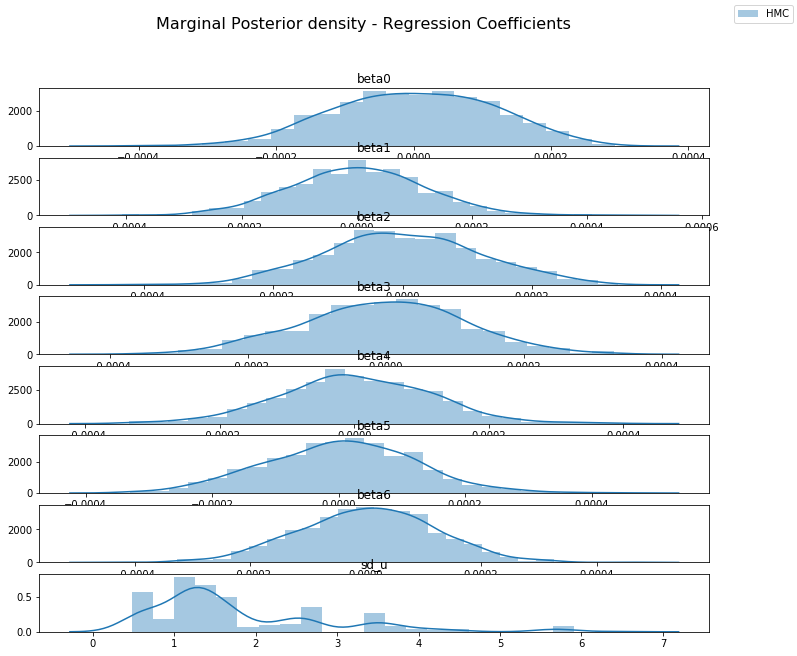

In [17]:
fig, axs = plt.subplots(nrows=8, ncols=1, figsize=(12, 10))
fig.suptitle("Marginal Posterior density - Regression Coefficients", fontsize=16)
for i, ax in enumerate(axs.reshape(-1)):
#     try:
    site = sites[i]
    print(site)
    sns.distplot(hmc_samples[site], ax=ax, label="HMC")        
    ax.set_title(site)
#     except:
#         pass
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right');

# normalize


In [18]:
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=200)
mcmc_run = mcmc.run(X_nuts_train, y_nuts_train, population,len(X_train.columns))

hmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}



sample:  33%|███▎      | 395/1200 [33:46<1:02:18,  4.64s/it, step size=3.55e-08, acc. prob=0.764]

KeyboardInterrupt: 

In [ ]:
for site, values in summary(hmc_samples).items():
    print("Site: {}".format(site))
    print(values, "\n")

In [ ]:
fig, axs = plt.subplots(nrows=8, ncols=1, figsize=(12, 10))
fig.suptitle("Marginal Posterior density - Regression Coefficients", fontsize=16)
for i, ax in enumerate(axs.reshape(-1)):
#     try:
    site = sites[i]
    print(site)
    sns.distplot(hmc_samples[site], ax=ax, label="HMC")        
    ax.set_title(site)
#     except:
#         pass
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right');